In [12]:
!pip install pandas
!pip install -U pip
!pip install -U matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.0.2
    Not uninstalling pip at /usr/lib/python3/dist-packages, outside environment /usr
    Can't uninstall 'pip'. No files were found to uninstall.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 24.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.6 MB/s eta 0:00:00


In [5]:
!ls ../Data

2D_poisson_eq_Dirichlet_BC.csv


In [1]:
import torch
import pandas as pd
import sys

sys.path.append("../DL_models")
sys.path.append("..")

from Models.GAN import *

### Poisson 2D
$$-\nabla^2 u(\mathbf{x})=f(\mathbf{x}) \ \mathbf{x} \in \Omega$$
$$u(\mathbf{x})=u_D(\mathbf{x}) \ \mathbf{x} \in \Omega$$

$$\mathbf{x}=[x,y] \ \Omega: [0,1]\times[0,1]$$

$$u_D(x,y)=1+x^2+2y^2$$
$$f(x,y)=-6$$

$$\Theta=[x,y]$$

In [17]:
def derivatives(u,x,n):
    if n==0:
        return u
    else:
        du=torch.autograd.grad(u,x,
        grad_outputs=torch.ones_like(u).to('cpu'),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
        )[0]
    return derivatives(du,x,n-1)


M=GAN_PI(
    G_params={"layers":[3,10,10,1],"activators":[torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Tanh()]},
    P_params={"layers":[3,10,10,1],"activators":[torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Tanh()]},
    D_params={"layers":[1,10,10,1],"activators":[torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Tanh()]},
    args_Gen={"W_posterior":0.99},
    args_PDE_res={
        "R":(lambda u,x:-1*(derivatives(u,x,2)[:,0]+derivatives(u,x,2)[:,1])),
        "f":(lambda u,x:1+x[:,0]**2+2*x[:,1]**2),
        "norm":lambda x:torch.mean(torch.abs(x))
    },
    args_PDE_sup={
        "norm":lambda x:torch.sum(torch.abs(x))
    },
    distribution_args={"mean":torch.tensor([[0.0]]), "std":torch.tensor([[1.0]])}
)

In [18]:
from Train import Trainer

In [19]:
optimizer=torch.optim.Adam(M.parameters(),lr=1e-5)
TT=Trainer(model_instance=M,data_path="../Data/2D_poisson_eq_Dirichlet_BC.csv",batch_size=100,optimizer=optimizer)

In [20]:
epoch_losses=[]
for i in range(100):
    losses=TT.train()
    epoch_losses.append(losses)

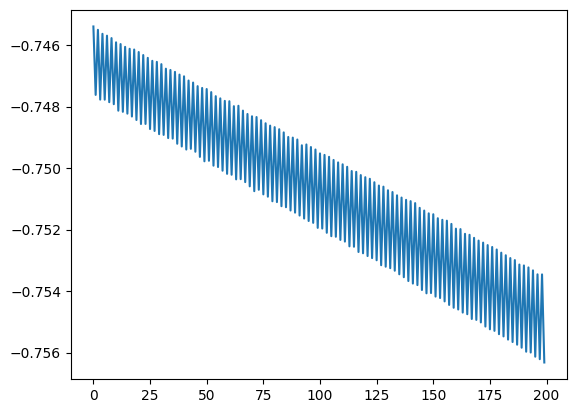

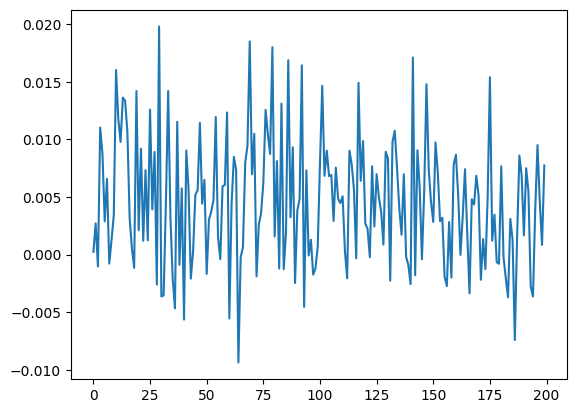

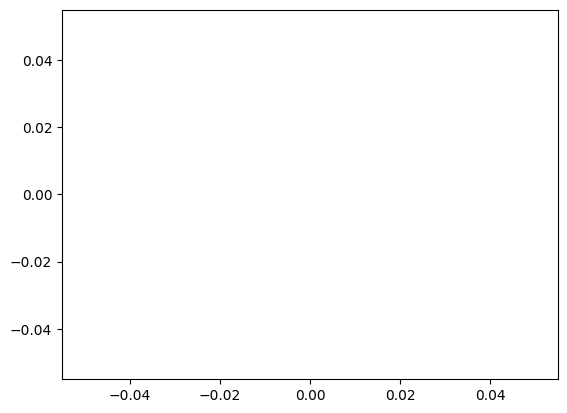

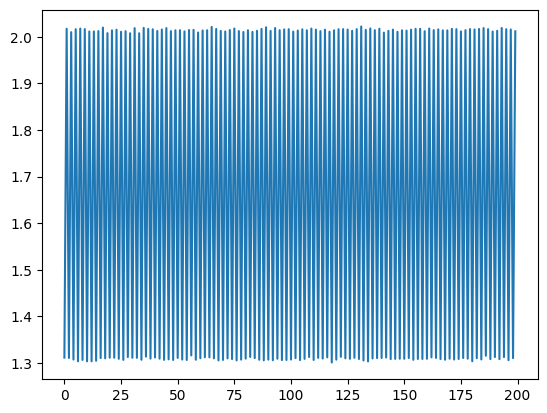

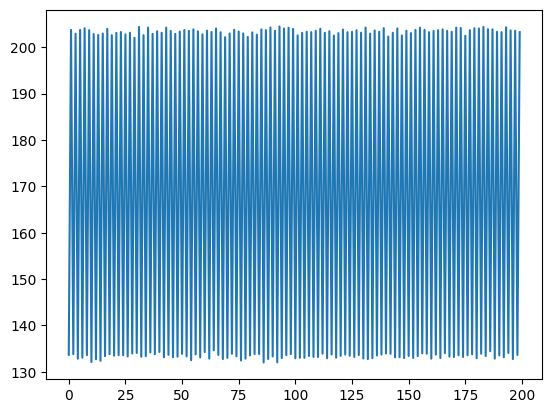

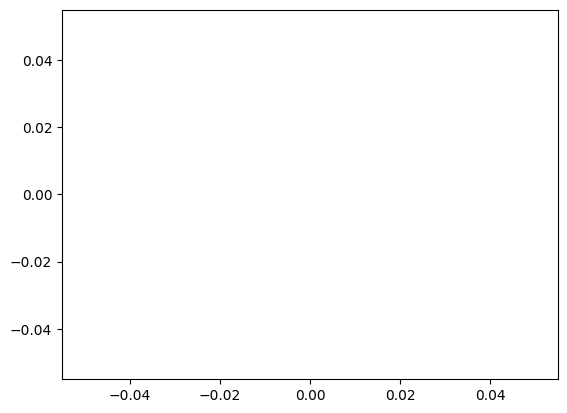

In [21]:
import matplotlib.pyplot as plt
from functools import reduce
losses=reduce(lambda x,y:x+y, epoch_losses)
plt.plot(list(map(lambda l:l["generative_posterior_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["generative_entropy_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["Discriminator_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["PDE_residual_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["PDE_supervised_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["total_loss"].cpu().detach().numpy(),losses)))

In [22]:
epoch_losses

[[{'generative_entropy_loss': tensor(0.0002, grad_fn=<MeanBackward0>),
   'generative_posterior_loss': tensor(-0.7454, grad_fn=<MeanBackward0>),
   'PDE_residual_loss': tensor(1.3115, grad_fn=<MeanBackward0>),
   'PDE_supervised_loss': tensor(133.6830, grad_fn=<SumBackward0>),
   'Discriminator_loss': tensor(nan, grad_fn=<AddBackward0>),
   'total_loss': tensor(nan, grad_fn=<SumBackward0>)},
  {'generative_entropy_loss': tensor(0.0027, grad_fn=<MeanBackward0>),
   'generative_posterior_loss': tensor(-0.7476, grad_fn=<MeanBackward0>),
   'PDE_residual_loss': tensor(2.0174, grad_fn=<MeanBackward0>),
   'PDE_supervised_loss': tensor(203.7447, grad_fn=<SumBackward0>),
   'Discriminator_loss': tensor(nan, grad_fn=<AddBackward0>),
   'total_loss': tensor(nan, grad_fn=<SumBackward0>)}],
 [{'generative_entropy_loss': tensor(-0.0010, grad_fn=<MeanBackward0>),
   'generative_posterior_loss': tensor(-0.7455, grad_fn=<MeanBackward0>),
   'PDE_residual_loss': tensor(1.3107, grad_fn=<MeanBackward0>)